##### This is an additional (bonus) notebook - _not annotated properly_ #####
The purpose of this notebook is to check if `atemp` feature is a function of other features typically mentioned in meteorological sources

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

import catboost as ctb
import lightgbm as lgbm
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

# minor settings
plt.style.use('ggplot')
%matplotlib inline

In [7]:
df_train = pd.read_csv('inputs/train.csv')
df_test = pd.read_csv('inputs/test.csv')

df = pd.concat([df_train, df_test], axis=0)

In [8]:
# Feels-like temperature
# https://www.wunderground.com/maps/temperature/feels-like

In [26]:
# Heat index equation
# https://www.wpc.ncep.noaa.gov/html/heatindex_equation.shtml

def check_HI(t, rh):
    T = (t*1.8) + 32 # T converted to degrees Fahrenheit
    RH = rh /100 # humidity represented as %

    # last part of equation is for conversion back to Celsius
    return ((-42.379 + 2.04901523*T + 10.14333127*RH - .22475541*T*RH - .00683783*T*T - .05481717*RH*RH + .00122874*T*T*RH + .00085282*T*RH*RH - .00000199*T*T*RH*RH) - 32) *(5/9) 

In [10]:
df['HI_equation'] = [check_HI(t, rh) for t, rh in zip(df['temp'], df['humidity'])]
df['delta_atemp_HI'] = df['atemp'] - df['HI_equation']

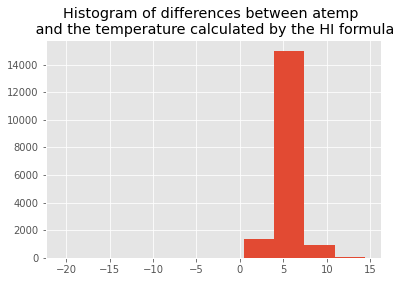

In [13]:
plt.title('Histogram of differences between atemp \n and the temperature calculated by the HI formula')
df['delta_atemp_HI'].hist();

In [14]:
# https://en.wikipedia.org/wiki/Wind_chill
def check_WC(t, v):
    # v = v * 1.609344 # we don't know if v is in mph or km/h
    return 13.12 + 0.6215*t - 11.37*v**0.16 + 0.3965*t*v**0.16

In [15]:
df['WC_equation'] = [check_WC(t, v) for t, v in zip(df['temp'], df['windspeed'])]
df['delta_atemp_WC'] = df['atemp'] - df['WC_equation']

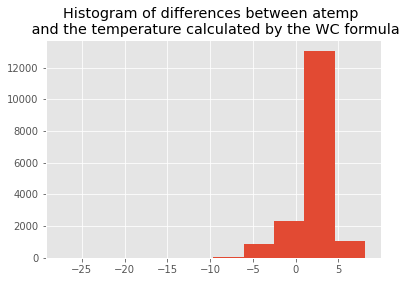

In [16]:
plt.title('Histogram of differences between atemp \n and the temperature calculated by the WC formula')
df['delta_atemp_WC'].hist();

Simple models - no hyperparameter tuning

In [17]:
df = df[['temp', 'atemp', 'humidity', 'windspeed', 'season']]

X = df.drop(['atemp'], axis = 1)
y = df['atemp']

In [20]:
xparams = {'n_estimators': 200, 'max_depth': 10, 'random_state': 0, 'verbosity':0, 'use_label_encoder': False }
cparams = {'n_estimators': 100, 'max_depth': 10, 'random_state': 0 , 'silent': True}
lparams = {'n_estimators': 100, 'max_depth': 10, 'random_state': 0, 'verbosity':-1, 'silent': True, 'force_row_wise':True}

models = [
    ('XGBoostRegressor', xgb.XGBRegressor(**xparams)),
    ('CatBoostRregressor',  ctb.CatBoostRegressor(**cparams)),
    ('LGBMRegressor', lgbm.LGBMRegressor(**lparams)),
    ('RandomForest', RandomForestRegressor())]

In [25]:

for model in models:
    model_name = model[0]
    model_obj = model[1]
    scores = cross_val_score(model_obj, X, y, cv=5, scoring='neg_mean_absolute_error')

    print(model_name, '\t', round(np.mean(scores),3), round(np.std(scores),3))

XGBoostRegressor 	 -0.099 0.034
CatBoostRregressor 	 -0.188 0.022
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
LGBMRegressor 	 -0.165 0.035
RandomForest 	 -0.088 0.038
